# 4 Modeling: Breast Cancer Gene Expressions <a id='4_modeling'></a>

 # 4.1 Contents
* [4 Modeling](#4_modeling)
    * [4.1 Contents](#4.1_contents)
    * [4.2 Introduction](#4.2_intro)
    * [4.3 Imports](#4.3_imports)
    * [4.4 Loading the Data](#4.4_loading)
    * [4.5 Preparing the Data for Modeling](#4.5_prep)
    * [4.6 The Models](#4.6_models)
        * [4.6.1 Logistic Regression](#4.6.1_logreg)
            * [4.6.1.a Logistic Regression Base Model (no resampling)](#4.6.1.a_logreg_base)
            * [4.6.1.b Logistic Regression for Oversampled Data](#4.6.1.b_logreg_os)
            * [4.6.1.c Logistic Regression for Undersampled Data](#4.6.1.c_logreg_us)
            * [4.6.1.d Logistic Regression - Hyperparameter Tuning](#4.6.1.d_logreg_tuning)
        * [4.6.2 Random Forest Classifier Model](#4.6.5_rf)
            * [4.6.2.a Random Forest Classifier, Oversampled](#4.6.2.a_rf_os)
            * [4.6.2.b Random Forest Classifier, Undersampled](#4.6.2.b_rf_us)
            * [4.6.2.c Hyperparameter Tuning](#4.6.2.c_rf_tuning)
        * [4.6.3 XG Boost Model](#4.6.3_xgb)
            * [4.6.3.a XG Boost, Oversampled](#4.6.3.a_xgb_os)
            * [4.6.3.b XG Boost, Undersampled](#4.6.3.b_xgb_us)
            * [4.6.3.c Hyperparameter Tuning](#4.6.3.c_xgb_tuning)
        * [4.6.4 LGBM Model](#4.6.4_lgbm)
            * [4.6.4.a LGBM, Oversampled](#4.6.4.a_lgbm_os)
            * [1.6.4.b LGBM, Undersampled](#4.6.4.b_lgbm_us)
            * [4.6.4.c Hyperparameter tuning](#4.6.4.c_lgbm_tuning)
        * [4.6.5 Precision Recall Curves](#4.6.5_pr)
        * [4.6.6 Model Selection](#4.6.6_selection)
        * [4.7 SHAP for Interpretation](#4.7_shap)
        * [4.8 Conclusions](#4.8_conclusions)
        * [4.9 Next Steps](#4.9_next)

## 4.2 Introduction <a id='4.2_intro'></a>

This notebook is dedicating to modeling the METABRIC breast cancer gene mutation dataset, picking the best model, and interpreting the results. 

Up until this point, I have cleaned and wrangled the data, performed EDA, and developed a baseline model using logistic regression. In attempt to reduce the number of features in my model, so as to minimize overfitting, I performed PCA, with 25, 190 and 360 components, and ran my model on these and the full dataset. The full dataset and the model with 190 components performed equally well, with a class 1 F1 score of 0.46, and I chose the full dataset so that I could preserve interpretability.

The F1 score for the baseline model was not good, and an important contributing factor to the poor predictive results are the imbalanced classes. To address this, I will resample the data, both via undersampling and oversampling, and run all of the models on both of these training data sets. 

The models that I will look at are Logistic Regression, Random Forest, XG Boost Classifier and LGBM Classifier. I will run over/undersampled base models for each, and then perform hyperparameter tuning. All of the F1 score and cross validation F1 score results will be stored in a dataframe for easy comparison. 

Finally, after selecting the best model I will use SHAP to interpret the results.

## 4.3 Imports <a id='4.3_imports'></a>

In [89]:
# data manipulation and math
#
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
#from sklearn.metrics import plot_precision_recall_curve
#
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV 

#classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# resampling tools
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss


import shap
import pickle
import time 
print("Loaded Libraries")

Loaded Libraries


## 4.4 Loading the Data <a id='4.4_loading'></a>

In [2]:
# Load the NumPy arrays from the pickle files
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_190.pkl', 'rb') as file:
    X_train_190 = pickle.load(file)
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_190.pkl', 'rb') as file:
    X_test_190 = pickle.load(file)  
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_360.pkl', 'rb') as file:
    X_train_360 = pickle.load(file)  
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_360.pkl', 'rb') as file:
    X_test_360 = pickle.load(file) 
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_full.pkl', 'rb') as file:
    X_train_full = pickle.load(file) 

with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_full.pkl', 'rb') as file:
    X_test_full = pickle.load(file) 
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\y_train.pkl', 'rb') as file:
    y_train = pickle.load(file) 
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\y_test.pkl', 'rb') as file:
    y_test = pickle.load(file) 
    
# importing using parquet to preserve data types - this is the full dataset used to create the splits above

num_data=pd.read_parquet(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\num_data2.parquet', engine='pyarrow')

## 4.5 Preparing the Data for Modeling <a id='4.5_prep'></a>

We have an imbalanced problem here: the class we are interested in (1, the patients who died of disease) are the minority class. As we saw in the EDA section, 33% of our data belongs to class 1.

As a solution to this, I am going to do resampling via the Synthetic Minority Over-sampling Technique (SMOTE), which synthesizes new data from within the minority class. It's an oversampling technique that should minimize overfitting. I also am going to try undersamping with NearMiss, and see how it compares. I will run all of the models on both of these resampled datasets. 


In [3]:
# Divide data into X and y

X=num_data.drop('outcome', axis=1)
y=num_data['outcome']

Do test train split:

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)


<b> Oversampling </b>

In [5]:
# Implement SMOTE:

sm = SMOTE(random_state=42)
X_train_os, y_train_os = sm.fit_resample(X_train, y_train)

In [6]:
# Confirming that our classes are now balanced

SMOTE_survival_counts = pd.Series(y_train_os).value_counts()
print('Outcomes:\n',100*SMOTE_survival_counts/len(y_train_os))

Outcomes:
 1    50.0
0    50.0
Name: outcome, dtype: float64


<b> Undersampling </b>

In [7]:
nm = NearMiss(version=1)
X_train_us, y_train_us = nm.fit_resample(X_train, y_train)

In [8]:
# Confirming that our classes are now balanced

undersampling_survival_counts = pd.Series(y_train_us).value_counts()
print('Outcomes:\n',100*undersampling_survival_counts/len(y_train_us))

Outcomes:
 0    50.0
1    50.0
Name: outcome, dtype: float64


I want to easily be able to compare all of the results, so I will append them to an empty I'm creating now dataframe, results_df:

In [9]:
results_df = pd.DataFrame(columns=['Model', 'Mean CV F1 Score', 'F1 Pos Class Score'] )

# 4.6 The Models <a id='4.6_models'></a>

## 4.6.1 Logistic Regression  <a id='4.6.1_logreg'></a>

### 4.6.1.a Logistic Regression Base Model (no resampling) <a id='4.6.1.a_logreg_base'></a>

This is our untuned logistic regression model on the data set with no resampling and no PCA. 

In [10]:
lr_model = LogisticRegression(solver = 'newton-cg', max_iter = 500) 
lr_model.fit(X_train,y_train)
y_predict_test = lr_model.predict(X_test)

scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, y_predict_test))

[0.40837696 0.42391304 0.39130435 0.46601942 0.41489362]
Mean CV F1 score for the positive class: 0.42 (+/- 0.05)
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       320
           1       0.45      0.50      0.47       156

    accuracy                           0.64       476
   macro avg       0.60      0.60      0.60       476
weighted avg       0.65      0.64      0.64       476



In [11]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test)
print(cm)

[[225  95]
 [ 78  78]]


In [12]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Base Model', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.47}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47


### 4.6.1.b Logistic Regression for Oversampled Data  <a id='4.6.1.b_logreg_os'></a>

In [13]:
lr_model_os = LogisticRegression(solver = 'newton-cg', max_iter = 500) 
lr_model_os.fit(X_train_os, y_train_os)
y_predict_test_os = lr_model_os.predict(X_test)

scores = cross_val_score(lr_model_os, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, y_predict_test_os))


[0.47435897 0.53211009 0.74879227 0.84513274 0.8590604 ]
Mean CV F1 score for the positive class: 0.69 (+/- 0.32)
              precision    recall  f1-score   support

           0       0.74      0.69      0.72       320
           1       0.45      0.51      0.47       156

    accuracy                           0.63       476
   macro avg       0.59      0.60      0.60       476
weighted avg       0.65      0.63      0.64       476



In [14]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_os)
print(cm)

[[222  98]
 [ 77  79]]


This is almost the same as the base model

In [15]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Oversampled Model', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.47}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47


### 4.6.1.c Logistic Regression for Undersampled Data  <a id='4.6.1.c_logreg_us'></a>

In [16]:
lr_model_us = LogisticRegression(solver = 'newton-cg', max_iter = 500) 
lr_model_us.fit(X_train_us, y_train_us)
y_predict_test_us = lr_model_us.predict(X_test)

scores = cross_val_score(lr_model_us, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, y_predict_test_us))

[0.75138122 0.69512195 0.73298429 0.7357513  0.70422535]
Mean CV F1 score for the positive class: 0.72 (+/- 0.04)
              precision    recall  f1-score   support

           0       0.80      0.50      0.62       320
           1       0.42      0.74      0.53       156

    accuracy                           0.58       476
   macro avg       0.61      0.62      0.58       476
weighted avg       0.67      0.58      0.59       476



In [17]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_us)
print(cm)

[[161 159]
 [ 41 115]]


The undersampled data set actually performs better at correctly identifying cancer deaths.

In [18]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Undersampled Model', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.53}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53


### 4.6.1.d Logistic Regression - Hyperparameter Tuning  <a id='4.6.1.d_logreg_tuning'></a>

In [19]:
# Define function to come up with cross validation scores: QUESTION - is this necessary or can I just use cross_val_score()?
def cv_score(clf, x, y, score_func = f1_score):
    result = 0
    nfold = 5
    x.reset_index(drop = True, inplace = True)
    y.index = x.index
    for train, test in KFold(nfold, shuffle = True,
                             random_state = 42).split(x):
        clf.fit(x.loc[train, :], y[train])
        result += score_func(clf.predict(x.loc[test, :]), y[test])
    return result / nfold

In [20]:
# Convert X_train_os and y_train to pandas DataFrames
X_train_os_df = pd.DataFrame(X_train_os)
y_train_os_df = pd.Series(y_train_os)
X_test_df = pd.DataFrame(X_test)
y_test_df=pd.Series(y_test)

# Convert X_train_us to pandas DataFrame
X_train_us_df = pd.DataFrame(X_train_us)
y_train_us_df = pd.DataFrame(y_train_us)

In [21]:
# Hyperparameter tuning using grid search

params={
    'penalty':['l1','l2'],
    'C':[0.001, 0.1, 1, 10, 100],
    }

# instantiate the model
logreg = LogisticRegression(solver='liblinear')

#  do GridSearchCV
grid_search= GridSearchCV(estimator=logreg,param_grid=params,cv=5, scoring='f1', n_jobs=-1)

# Oversampled Data
grid_search.fit(X_train_os,y_train_os)

# print best hyperparameters and F1 score
print("Best hyperparameters for oversampled data:", grid_search.best_params_)
print("Accuracy score for oversampled data:", grid_search.best_score_)

# Undersampled data
grid_search.fit(X_train_us,y_train_us)

# print best hyperparameters and F1 score
print("\nBest hyperparameters for undersampled data:", grid_search.best_params_)
print("F1 score for undersampled data:", grid_search.best_score_)



Best hyperparameters for oversampled data: {'C': 0.1, 'penalty': 'l1'}
Accuracy score for oversampled data: 0.7247556744079577

Best hyperparameters for undersampled data: {'C': 0.001, 'penalty': 'l2'}
F1 score for undersampled data: 0.7697456598473039


<b> Oversampled Data </b>

changing solver to 'liblinear' as it supports l1 penalty, and 'saga' got convergence errors with the same result

In [22]:
lr_model_os_tuned = LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.1, penalty='l1') 
lr_model_os_tuned.fit(X_train_os, y_train_os)
y_predict_test_tuned_os = lr_model_os.predict(X_test)

scores = cross_val_score(lr_model_os_tuned, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, y_predict_test_tuned_os))


[0.53250774 0.59235669 0.76683938 0.86896552 0.86310905]
Mean CV F1 score for the positive class: 0.72 (+/- 0.28)
              precision    recall  f1-score   support

           0       0.74      0.69      0.72       320
           1       0.45      0.51      0.47       156

    accuracy                           0.63       476
   macro avg       0.59      0.60      0.60       476
weighted avg       0.65      0.63      0.64       476



In [23]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_tuned_os)
print(cm)

[[222  98]
 [ 77  79]]


In [24]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Oversampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.47}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47


<b> Oversampled Data </b>

In [25]:
lr_model_us_tuned = LogisticRegression(solver = 'newton-cg', max_iter = 500, C=0.001, penalty='l2') 
lr_model_us_tuned.fit(X_train_us, y_train_us)
y_predict_test_tuned_us = lr_model_us.predict(X_test)

scores = cross_val_score(lr_model_us_tuned, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print(classification_report(y_test, y_predict_test_tuned_us))


[0.8502994  0.71428571 0.77966102 0.75824176 0.7254902 ]
Mean CV F1 score for the positive class: 0.77 (+/- 0.10)
              precision    recall  f1-score   support

           0       0.80      0.50      0.62       320
           1       0.42      0.74      0.53       156

    accuracy                           0.58       476
   macro avg       0.61      0.62      0.58       476
weighted avg       0.67      0.58      0.59       476



In [26]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_tuned_us)
print(cm)

[[161 159]
 [ 41 115]]


In [27]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Undersampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.53}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53


## 4.6.2 Random Forest Classifier Model <a id='4.6.5_rf'></a>

### 4.6.2.a Random Forest Classifier, Oversampled  <a id='4.6.2.a_rf_os'></a>

In [29]:
# Create the model
rfc_os = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rfc_os.fit(X_train_os, y_train_os)

# Predict the labels of the test set
y_predict_test_os_rf = rfc_os.predict(X_test)


scores = cross_val_score(rfc_os, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# Test classification report, all components: 
print('Random Forest Model: Test data, Oversampled:\n',classification_report(y_test,y_predict_test_os_rf))


[0.67283951 0.69538462 0.82539683 0.89371981 0.88674699]
Mean CV F1 score for the positive class: 0.79 (+/- 0.19)
Random Forest Model: Test data, Oversampled:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79       320
           1       0.53      0.31      0.40       156

    accuracy                           0.68       476
   macro avg       0.63      0.59      0.59       476
weighted avg       0.66      0.68      0.66       476



In [30]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_os_rf)
print(cm)

[[277  43]
 [107  49]]


In [31]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Random Forest, Oversampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.40}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40


### 4.6.2.b Random Forest Classifier, Undersampled  <a id='4.6.2.b_rf_us'></a>

In [32]:
# Create the model
rfc_us = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rfc_us.fit(X_train_us, y_train_us)

# Predict the labels of the test set
y_predict_test_us_rf = rfc_us.predict(X_test)


scores = cross_val_score(rfc_us, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)
print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Test classification report, all components: 
print('Random Forest Model: Test data, Undersampled:\n',classification_report(y_test,y_predict_test_us_rf))


[0.83950617 0.72839506 0.75       0.74509804 0.69194313]
Mean CV F1 score for the positive class: 0.75 (+/- 0.10)
Random Forest Model: Test data, Undersampled:
               precision    recall  f1-score   support

           0       0.77      0.45      0.57       320
           1       0.39      0.72      0.51       156

    accuracy                           0.54       476
   macro avg       0.58      0.59      0.54       476
weighted avg       0.65      0.54      0.55       476



In [33]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_us_rf)
print(cm)

[[145 175]
 [ 43 113]]


In [34]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Random Forest, Undersampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.51}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51


### 4.6.2.c Hyperparameter tuning <a id='4.6.2.c_rf_tuning'></a>

<b> Oversampled </b>

In [35]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a base model
rfc_os = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc_os, param_grid = param_grid, 
                           cv = 5, scoring='f1', n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_os, y_train_os)

# Get the best parameters
print(grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


<b> Tuning the model </b>

In [36]:
# Create the model
rfc_os_tuned = RandomForestClassifier(n_estimators=300, max_depth=10,min_samples_leaf=2,min_samples_split=2, random_state=42)

# Fit the model
rfc_os_tuned.fit(X_train_os, y_train_os)

# Predict the labels of the test set
y_predict_test_os_rf_tuned = rfc_os_tuned.predict(X_test)


scores = cross_val_score(rfc_os_tuned, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# Test classification report, all components: 
print('Random Forest Model: Test data, Oversampled:\n',classification_report(y_test,y_predict_test_os_rf_tuned))


[0.73802817 0.77746479 0.81841432 0.88056206 0.8591224 ]
Mean CV F1 score for the positive class: 0.81 (+/- 0.10)
Random Forest Model: Test data, Oversampled:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       320
           1       0.51      0.46      0.49       156

    accuracy                           0.68       476
   macro avg       0.63      0.62      0.63       476
weighted avg       0.67      0.68      0.68       476



In [37]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_os_rf_tuned)
print(cm)

[[252  68]
 [ 84  72]]


In [38]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Random Forest, Oversampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.49}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49


<b> Undersampled, Tuned </b>

In [39]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a base model
rfc_us = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc_us, param_grid = param_grid, 
                           cv = 5, scoring='f1', n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_us, y_train_us)

# Get the best parameters
print(grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}


In [40]:
# Create the model
rfc_us_tuned = RandomForestClassifier(n_estimators=300, max_depth=10,min_samples_leaf=4,min_samples_split=2, random_state=42)

# Fit the model
rfc_us_tuned.fit(X_train_us, y_train_us)

# Predict the labels of the test set
y_predict_test_us_rf_tuned = rfc_us_tuned.predict(X_test)


scores = cross_val_score(rfc_us_tuned, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# Test classification report, all components: 
print('Random Forest Model: Test data, Oversampled:\n',classification_report(y_test,y_predict_test_us_rf_tuned))


[0.84146341 0.73619632 0.80446927 0.75247525 0.71497585]
Mean CV F1 score for the positive class: 0.77 (+/- 0.09)
Random Forest Model: Test data, Oversampled:
               precision    recall  f1-score   support

           0       0.79      0.47      0.59       320
           1       0.41      0.74      0.52       156

    accuracy                           0.56       476
   macro avg       0.60      0.61      0.56       476
weighted avg       0.66      0.56      0.57       476



In [41]:
# confusion matrix
cm = confusion_matrix(y_test, y_predict_test_us_rf_tuned)
print(cm)

[[150 170]
 [ 40 116]]


In [42]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Random Forest, Undersampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.52}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52


## 4.6.3 XG Boost Model  <a id='4.6.3_xgb'></a>

### 4.6.3.a XG Boost, Oversampled <a id='4.6.3.a_xgb_os'></a>

In [43]:
# fit model
xgboost_model_os = XGBClassifier()
xgboost_model_os.fit(X_train_os, y_train_os)

# make predictions for test data
xgboost_y_pred_os = xgboost_model_os.predict(X_test)
predictions = [round(value) for value in xgboost_y_pred_os]


scores = cross_val_score(xgboost_model_os, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, XG Boost, Oversampled',classification_report(y_test, xgboost_y_pred_os))

[0.60450161 0.72072072 0.81794195 0.89719626 0.89929742]
Mean CV F1 score for the positive class: 0.79 (+/- 0.23)
Test Classification Report, XG Boost, Oversampled               precision    recall  f1-score   support

           0       0.75      0.83      0.79       320
           1       0.55      0.43      0.48       156

    accuracy                           0.70       476
   macro avg       0.65      0.63      0.64       476
weighted avg       0.69      0.70      0.69       476



In [44]:
# confusion matrix
cm = confusion_matrix(y_test, xgboost_y_pred_os)
print(cm)

[[266  54]
 [ 89  67]]


In [45]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'XG Boost, Oversampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.48}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


### 4.6.3.b XG Boost, Undersampled <a id='4.6.3.b_xgb_us'></a>

In [46]:
# fit model
xgboost_model_us = XGBClassifier()
xgboost_model_us.fit(X_train_us, y_train_us)

# make predictions for test data
xgboost_y_pred_us = xgboost_model_us.predict(X_test)
predictions = [round(value) for value in xgboost_y_pred_us]


scores = cross_val_score(xgboost_model_us, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, XG Boost, Undersampled',classification_report(y_test, xgboost_y_pred_us))

[0.82840237 0.72392638 0.74193548 0.75126904 0.71428571]
Mean CV F1 score for the positive class: 0.75 (+/- 0.08)
Test Classification Report, XG Boost, Undersampled               precision    recall  f1-score   support

           0       0.81      0.49      0.61       320
           1       0.43      0.77      0.55       156

    accuracy                           0.58       476
   macro avg       0.62      0.63      0.58       476
weighted avg       0.69      0.58      0.59       476



In [47]:
# confusion matrix
cm = confusion_matrix(y_test, xgboost_y_pred_us)
print(cm)

[[158 162]
 [ 36 120]]


In [48]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'XG Boost, Undersampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.55}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


NOTE: This is the best one so far, as far as the F1 score goes

### 4.6.3.c Hyperparameter Tuning  <a id='4.6.3.c_xgb_tuning'></a>

<b> Oversampled </b>

In [49]:
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 2, 3],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the classifier
xgboost_model_os = XGBClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_model_os, param_grid=grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_os, y_train_os)

# Print the best parameters found
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200}
0.7998481713612512


Apply the tuned hyperparameters:

In [73]:
# fit model
xgboost_model_os_tuned = XGBClassifier(gamma=0,learning_rate=0.05,min_child_weight=1,n_estimators=200)
xgboost_model_os_tuned.fit(X_train_os, y_train_os)

# make predictions for test data
xgboost_y_pred_os_tuned = xgboost_model_os_tuned.predict(X_test)
predictions = [round(value) for value in xgboost_y_pred_os_tuned]


scores = cross_val_score(xgboost_model_os_tuned, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, XG Boost, Oversampled, Tuned',classification_report(y_test, xgboost_y_pred_os_tuned))

[0.67307692 0.69538462 0.84574468 0.8951049  0.88992974]
Mean CV F1 score for the positive class: 0.80 (+/- 0.19)
Test Classification Report, XG Boost, Oversampled, Tuned               precision    recall  f1-score   support

           0       0.74      0.84      0.79       320
           1       0.56      0.40      0.47       156

    accuracy                           0.70       476
   macro avg       0.65      0.62      0.63       476
weighted avg       0.68      0.70      0.69       476



In [51]:
# confusion matrix
cm = confusion_matrix(y_test, xgboost_y_pred_os_tuned)
print(cm)

[[266  54]
 [ 89  67]]


In [52]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'XG Boost, Oversampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.47}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


<b> Undersampled </b>

In [53]:
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 6],
    'min_child_weight': [1, 2, 3],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.1, 0.2]
}

# Initialize the classifier
xgboost_model_us_tuned = XGBClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_model_us_tuned, param_grid=grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_us, y_train_us)

# Print the best parameters found
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200}
0.7621981384459869


Applying the tuned hyperparameters:

In [54]:
# fit model
xgboost_model_us_tuned = XGBClassifier(gamma= 0, learning_rate=0.05, max_depth= 6, min_child_weight=1, n_estimators=200)
xgboost_model_us_tuned.fit(X_train_us, y_train_us)

# make predictions for test data
xgboost_y_pred_us_tuned = xgboost_model_us_tuned.predict(X_test)
predictions = [round(value) for value in xgboost_y_pred_us_tuned]


scores = cross_val_score(xgboost_model_us_tuned, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, XG Boost, Undersampled, Tuned',classification_report(y_test, xgboost_y_pred_us_tuned))

[0.82142857 0.73493976 0.77777778 0.76530612 0.71153846]
Mean CV F1 score for the positive class: 0.76 (+/- 0.08)
Test Classification Report, XG Boost, Undersampled, Tuned               precision    recall  f1-score   support

           0       0.84      0.50      0.63       320
           1       0.44      0.81      0.57       156

    accuracy                           0.60       476
   macro avg       0.64      0.65      0.60       476
weighted avg       0.71      0.60      0.61       476



In [55]:
# confusion matrix
cm = confusion_matrix(y_test, xgboost_y_pred_us_tuned)
print(cm)

[[160 160]
 [ 30 126]]


In [56]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'XG Boost, Undersampled, Tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.57}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


XG Boost, undersampled and tuned is the best so far!

## 4.6.4 LGBM Model  <a id='4.6.4_lgbm'></a>

### 4.6.4.a LGBM, Oversampled <a id='4.6.4.a_lgbm_os'></a>

In [57]:
# using this method: https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

#create the model

lgbm_model_os= LGBMClassifier()

# fit the model
lgbm_model_os.fit(X_train_os, y_train_os)

# make predictions for test data
lgbm_y_pred_os = lgbm_model_os.predict(X_test)
predictions = [round(value) for value in lgbm_y_pred_os]


scores = cross_val_score(lgbm_model_os, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, LGBM, Oversampled',classification_report(y_test, lgbm_y_pred_os))

[0.61073826 0.64761905 0.82414698 0.90140845 0.89671362]
Mean CV F1 score for the positive class: 0.78 (+/- 0.25)
Test Classification Report, LGBM, Oversampled               precision    recall  f1-score   support

           0       0.75      0.83      0.79       320
           1       0.56      0.43      0.49       156

    accuracy                           0.70       476
   macro avg       0.65      0.63      0.64       476
weighted avg       0.69      0.70      0.69       476



In [58]:
# confusion matrix
cm = confusion_matrix(y_test, lgbm_y_pred_os)
print(cm)

[[267  53]
 [ 89  67]]


In [59]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'LGBM Model, Oversampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.49}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


### 4.6.4.b LGBM, Undersampled <a id='4.6.4.b_lgbm_us'></a>

In [60]:
#create the model

lgbm_model_us= LGBMClassifier()

# fit the model
lgbm_model_us.fit(X_train_us, y_train_us)

# make predictions for test data
lgbm_y_pred_us = lgbm_model_us.predict(X_test)
predictions = [round(value) for value in lgbm_y_pred_us]


scores = cross_val_score(lgbm_model_us, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, LGBM, Undersampled',classification_report(y_test, lgbm_y_pred_us))

[0.82352941 0.73619632 0.75280899 0.75376884 0.71962617]
Mean CV F1 score for the positive class: 0.76 (+/- 0.07)
Test Classification Report, LGBM, Undersampled               precision    recall  f1-score   support

           0       0.84      0.49      0.62       320
           1       0.44      0.81      0.57       156

    accuracy                           0.59       476
   macro avg       0.64      0.65      0.59       476
weighted avg       0.71      0.59      0.60       476



In [61]:
# confusion matrix
cm = confusion_matrix(y_test, lgbm_y_pred_us)
print(cm)

[[157 163]
 [ 30 126]]


In [62]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'LGBM Model, Undersampled', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.57}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


### 4.6.4.c Hyperparameter tuning<a id='4.6.4.c_lgbm_tuning'></a>

In [63]:
grid = {
    'num_leaves': [31, 127],
    'min_child_samples': [20, 30, 40],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Initialize the classifier
lgbm_model_os = LGBMClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgbm_model_os, param_grid=grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_os, y_train_os)

# Print the best parameters found
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'learning_rate': 0.2, 'max_depth': 7, 'min_child_samples': 20, 'num_leaves': 31}
0.8006962542460357


In [64]:
# apply the tuned hyperparameters:

lgbm_model_os_tuned= LGBMClassifier(num_leaves=31,min_child_samples=20,max_depth=7,learning_rate=0.2)

# fit the model
lgbm_model_os_tuned.fit(X_train_os, y_train_os)

# make predictions for test data
lgbm_y_pred_os_tuned = lgbm_model_os_tuned.predict(X_test)
predictions = [round(value) for value in lgbm_y_pred_os_tuned]


scores = cross_val_score(lgbm_model_os_tuned, X_train_os, y_train_os, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, LGBM, Oversampled',classification_report(y_test, lgbm_y_pred_os_tuned))

[0.67507886 0.68125    0.82506527 0.91428571 0.90780142]
Mean CV F1 score for the positive class: 0.80 (+/- 0.21)
Test Classification Report, LGBM, Oversampled               precision    recall  f1-score   support

           0       0.74      0.83      0.78       320
           1       0.54      0.39      0.45       156

    accuracy                           0.69       476
   macro avg       0.64      0.61      0.62       476
weighted avg       0.67      0.69      0.67       476



In [65]:
# confusion matrix
cm = confusion_matrix(y_test, lgbm_y_pred_os_tuned)
print(cm)

[[267  53]
 [ 95  61]]


In [66]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'LGBM Model, Oversampled, tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.45}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


<b>Undersampled</b>

In [67]:
grid = {
    'num_leaves': [31, 127],
    'min_child_samples': [20, 30, 40],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Initialize the classifier
lgbm_model_us = LGBMClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lgbm_model_us, param_grid=grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_us, y_train_us)

# Print the best parameters found
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'learning_rate': 0.2, 'max_depth': 7, 'min_child_samples': 20, 'num_leaves': 31}
0.7612449110387799


In [68]:
# apply the tuned hyperparameters:

lgbm_model_us_tuned= LGBMClassifier(num_leaves=31,min_child_samples=20,max_depth=7,learning_rate=0.2)

# fit the model
lgbm_model_us_tuned.fit(X_train_us, y_train_us)

# make predictions for test data
lgbm_y_pred_us_tuned = lgbm_model_us_tuned.predict(X_test)
predictions = [round(value) for value in lgbm_y_pred_us_tuned]


scores = cross_val_score(lgbm_model_us_tuned, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report, LGBM, Undersampled',classification_report(y_test, lgbm_y_pred_us_tuned))

[0.83529412 0.71604938 0.76300578 0.75757576 0.73429952]
Mean CV F1 score for the positive class: 0.76 (+/- 0.08)
Test Classification Report, LGBM, Undersampled               precision    recall  f1-score   support

           0       0.81      0.50      0.62       320
           1       0.42      0.76      0.54       156

    accuracy                           0.58       476
   macro avg       0.62      0.63      0.58       476
weighted avg       0.68      0.58      0.59       476



In [69]:
# confusion matrix
cm = confusion_matrix(y_test, lgbm_y_pred_us_tuned)
print(cm)

[[160 160]
 [ 38 118]]


In [70]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'LGBM Model, Undersampled, tuned', 'Mean CV F1 Score': round(scores.mean(),2), 'F1 Pos Class Score':0.54}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
4,"Logistic Regression Undersampled, Tuned",0.77,0.53
5,"Random Forest, Oversampled",0.79,0.40
6,"Random Forest, Undersampled",0.75,0.51
7,"Random Forest, Oversampled, Tuned",0.81,0.49
8,"Random Forest, Undersampled, Tuned",0.77,0.52
9,"XG Boost, Oversampled",0.79,0.48


This is actually worse than when it was untuned.

In [71]:
# Sort results by F1 pos class score
results_df.sort_values(by='F1 Pos Class Score')

,Model,Mean CV F1 Score,F1 Pos Class Score
5,"Random Forest, Oversampled",0.79,0.40
15,"LGBM Model, Oversampled, tuned",0.80,0.45
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
11,"XG Boost, Oversampled, Tuned",0.79,0.48
9,"XG Boost, Oversampled",0.79,0.48
13,"LGBM Model, Oversampled",0.78,0.49
7,"Random Forest, Oversampled, Tuned",0.81,0.49
6,"Random Forest, Undersampled",0.75,0.51


In [72]:
# Sort results by mean CV F1 score
results_df.sort_values(by='Mean CV F1 Score')

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression Base Model,0.42,0.47
1,Logistic Regression Oversampled Model,0.69,0.47
2,Logistic Regression Undersampled Model,0.72,0.53
3,"Logistic Regression Oversampled, Tuned",0.72,0.47
6,"Random Forest, Undersampled",0.75,0.51
10,"XG Boost, Undersampled",0.75,0.55
14,"LGBM Model, Undersampled",0.76,0.57
12,"XG Boost, Undersampled, Tuned",0.76,0.57
16,"LGBM Model, Undersampled, tuned",0.76,0.54
4,"Logistic Regression Undersampled, Tuned",0.77,0.53


## 1.6.5 Precision Recall Curves <a id='4.6.5_pr'></a>

Plotting a precision recall curve for all of the models.

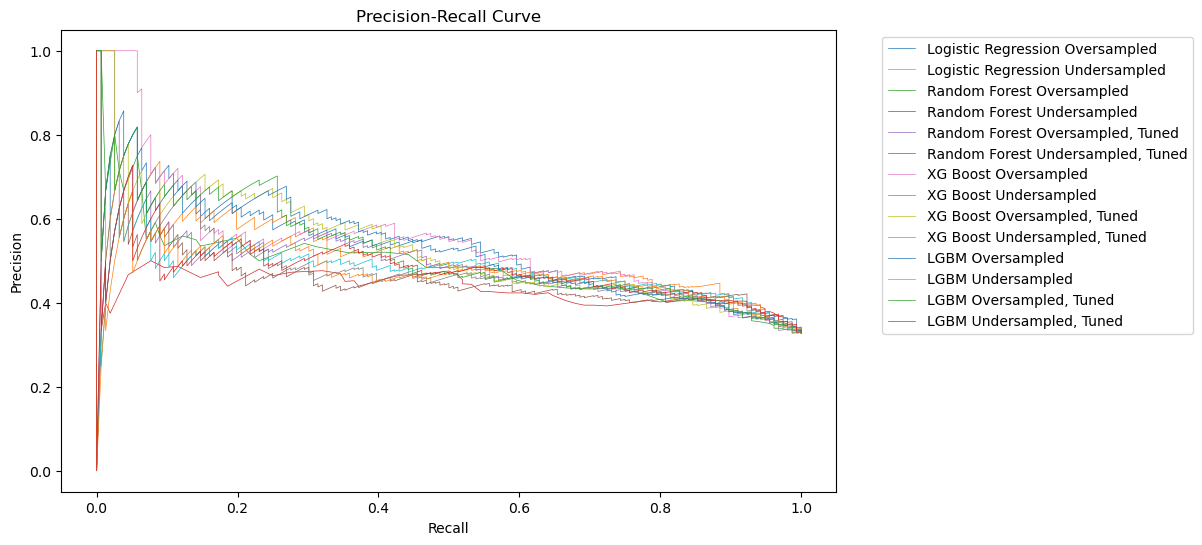

In [83]:
models = {
    'Logistic Regression Oversampled': LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.1, penalty='l1'),
    'Logistic Regression Undersampled': LogisticRegression(solver = 'newton-cg', max_iter = 500, C=0.001, penalty='l2'),
	'Random Forest Oversampled': RandomForestClassifier(n_estimators=100, random_state=42),
	'Random Forest Undersampled': RandomForestClassifier(n_estimators=100, random_state=42),
	'Random Forest Oversampled, Tuned': RandomForestClassifier(n_estimators=300, max_depth=10,min_samples_leaf=2,min_samples_split=2, random_state=42),
	'Random Forest Undersampled, Tuned': RandomForestClassifier(n_estimators=300, max_depth=10,min_samples_leaf=4,min_samples_split=2, random_state=42),
	'XG Boost Oversampled': XGBClassifier(),
	'XG Boost Undersampled': XGBClassifier(),
	'XG Boost Oversampled, Tuned': XGBClassifier(gamma=0,learning_rate=0.05,min_child_weight=1,n_estimators=200),
	'XG Boost Undersampled, Tuned': XGBClassifier(gamma= 0, learning_rate=0.05, max_depth= 6, min_child_weight=1, n_estimators=200),
	'LGBM Oversampled': LGBMClassifier(),
	'LGBM Undersampled': LGBMClassifier(),
	'LGBM Oversampled, Tuned':  LGBMClassifier(num_leaves=31,min_child_samples=20,max_depth=7,learning_rate=0.2),
	'LGBM Undersampled, Tuned':LGBMClassifier(num_leaves=31,min_child_samples=20,max_depth=7,learning_rate=0.2),
}

training_data = {
    'Logistic Regression Oversampled': (X_train_os, y_train_os),
    'Logistic Regression Undersampled': (X_train_us, y_train_us),
	'Random Forest Oversampled': (X_train_os, y_train_os),
	'Random Forest Undersampled': (X_train_us, y_train_us),
	'Random Forest Oversampled, Tuned': (X_train_os, y_train_os),
	'Random Forest Undersampled, Tuned': (X_train_us, y_train_us),
	'XG Boost Oversampled': (X_train_os, y_train_os),
    'XG Boost Undersampled': (X_train_us, y_train_us),
	'XG Boost Oversampled, Tuned': (X_train_os, y_train_os),
    'XG Boost Undersampled, Tuned': (X_train_us, y_train_us),
	'LGBM Oversampled': (X_train_os, y_train_os),
    'LGBM Undersampled': (X_train_us, y_train_us),
	'LGBM Oversampled, Tuned': (X_train_os, y_train_os),
    'LGBM Undersampled, Tuned': (X_train_us, y_train_us),
}
# Use the same test data for all models
testing_data = X_test

# Set the size of the figure (in inches)
plt.figure(figsize=(10, 6))

for name, model in models.items():
    X_train_res, y_train_res = training_data[name]
    model.fit(X_train_res, y_train_res) 
    y_scores = model.predict_proba(testing_data)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    
    # Plot the precision-recall curve with a specified line width
    plt.plot(recall, precision, linewidth=0.5, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Place the legend outside the plot area
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


We can clearly see from these precision recall curves that none of these models are very good at predicting cancer death. Our best model (see the following section for how I chose this), the XG Boost  Undersampled & Tuned, has a precision score of only 0.44, but a recall score of 0.81. This means that our model has a lot of false positives, which means that patients who will not die of cancer could be told that they will die of cancer, but that most of the true positives are identified, which lines up with our ultimate goal of identifying which patients will die of cancer. 

## 1.6.6 Model Selection <a id='4.6.6_selection'></a>

<b>CONCLUSION:</b>

I used 4 different models, Logistic Regression, Random Forest, XG Boost, and LGBM Classifier. I used each model on oversampled and undersampled data, and also performed hyperparameter tuning and reran the models. For each model iteration, I found the mean cross validation F1 score, and printed a classification report and confusion matrix. 

The goal of this project is to be able to predict cancer death, and hopefully identify what factors contribute to cancer death. As our '1' class in our target signifies cancer death, the F1 score of the 1 class is the metric we are the most concerned with, and this the basis of selecting the best model. 

According to these standards, the XG Boost, Undersampled & Tuned and the LGBM, Undersampled (not tuned) performed the best, with a F1 score of the positive class of 0.57. By looking at the rest of the metrics, XG Boost, Undersampled & Tuned was the best model I tested. 



In [87]:
# This is our best model, XGBClassifier, using undersampling & with hyperparameter tuning. I'm renaming it and looking 
# at the report again for the sake of organization

best_model = XGBClassifier(gamma= 0, learning_rate=0.05, max_depth= 6, min_child_weight=1, n_estimators=200)
best_model.fit(X_train_us, y_train_us)

# make predictions for test data
best_y_predictions = best_model.predict(X_test)
predictions = [round(value) for value in best_y_predictions]


scores = cross_val_score(best_model, X_train_us, y_train_us, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print('Test Classification Report for our chosen model(XG Boost, Undersampled, Tuned)',classification_report(y_test, best_y_predictions))

[0.82142857 0.73493976 0.77777778 0.76530612 0.71153846]
Mean CV F1 score for the positive class: 0.76 (+/- 0.08)
Test Classification Report for our chosen model(XG Boost, Undersampled, Tuned)               precision    recall  f1-score   support

           0       0.84      0.50      0.63       320
           1       0.44      0.81      0.57       156

    accuracy                           0.60       476
   macro avg       0.64      0.65      0.60       476
weighted avg       0.71      0.60      0.61       476



# 4.7 SHAP for Interpretation <a id='4.7_shap'></a>

I have found the best model of those I tested, but what do the results mean? Below I am using SHAP to identify features that contribute towards cancer mortality. The SHAP value contributes towards our target outcome, so a higher SHAP value means that the is more contribution towards cancer death, and a negative SHAP value means that there is more contribution towards no cancer death. 

<b>Use SHAP:</b>

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


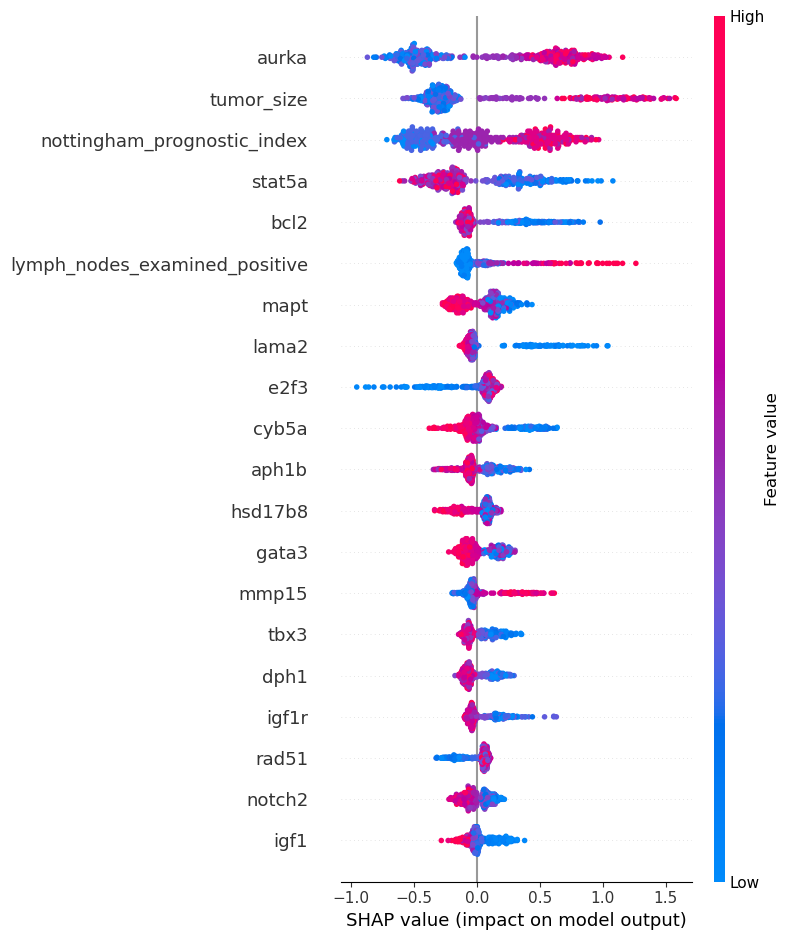

In [90]:
# create the SHAP Explainer object with your fitted model
explainer = shap.TreeExplainer(best_model)

# compute SHAP values
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

In the above plot we can clearly see that there are definitely features which contibute towards patient outcomes. It appears that how the data are distributed for each of these features can have measurable impact on the patient outcome. Interestingly, most of these are genes, which means that the z score for a particular gene is important in looking at outcomes. There are also a few clinical attributes that look important. No gene mutation data is showing up with high SHAP values. 

In [98]:
# Ranking Feature Importance- this is another way to look at the data in the plot above: 

# calculate the mean absolute SHAP value for each feature
feature_importance = np.mean(np.abs(shap_values), axis=0)

# get the names of the features from the column names of the dataset
feature_names = X_test.columns

# create a DataFrame of the feature names and importance
importance_df = pd.DataFrame(list(zip(feature_names, feature_importance)), 
                              columns=['Feature','Importance'])

# sort the DataFrame in descending order of importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df = importance_df[importance_df['Importance']>0]

importance_df.head(30)

,Feature,Importance
207,aurka,0.546425
4,tumor_size,0.469747
3,nottingham_prognostic_index,0.384076
139,stat5a,0.313667
209,bcl2,0.192631
1,lymph_nodes_examined_positive,0.156174
389,mapt,0.154170
445,lama2,0.141154
127,e2f3,0.136532
525,cyb5a,0.129698


Below I am looking at the individual features identified above as having mean SHAP values over the absolute value of 0.1. 

A note on the analysis below: the continuous features all fell into 2 distinct clusters, most often of SHAP values over 0 and under 0.  A higher SHAP value corresponds to that feature contributing more towards a patient dying of cancer (target value of 1, as opposed to 0). A lower SHAP value corresponds to a feature contributing towards not dying of cancer. The two categorical features (Nottingham Prognostic Index and Lymph Nodes Examined Positive) both followed a roughly linear trend, with higher values corresponding to  higher SHAP value. 
The following features are discussed ranked from the highest mean SHAP  value down. 


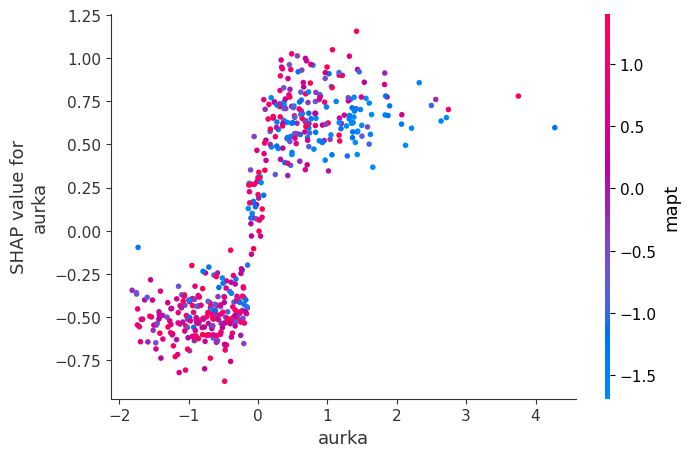

In [103]:
# inspecting the Aurka gene's SHAP value
shap.dependence_plot('aurka', shap_values, X_test)

The aurka gene has the most impact on survival of all the features in our dataset, when looking at the SHAP value plots they are clearly divided into two clusters: positive z scores contributed to higher likelihood of cancer death (SHAP values mostly between 0.25-1), negative z scores contributed to lower likelihood of cancer death. The clusters were more widely spaced than the other genes. 

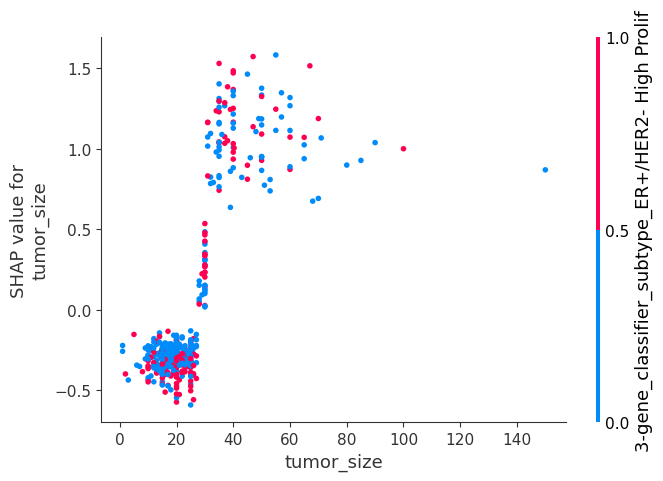

In [104]:
# inspecting tumor size SHAP value
shap.dependence_plot('tumor_size', shap_values, X_test)

Tumor size is another important factor. There are two distinct clusters right at a  tumor size of ‘30’. Over 30 have higher SHAP values, mostly in the 0.5-1.5 range, and under 30 have SHAP values under 0. 


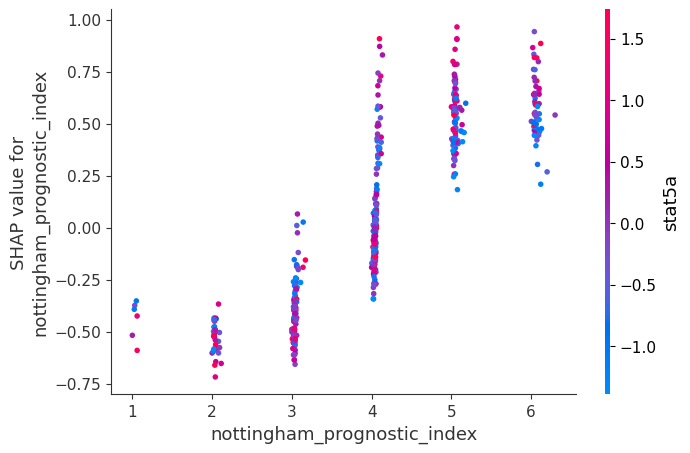

In [105]:
# inspecting the Nottingham Progostic Index SHAP value
shap.dependence_plot('nottingham_prognostic_index', shap_values, X_test)

We can see that as the Nottingham Prognostic Index increases, so does the SHAP value. At an index  of 4, the SHAP values range from 0.25-1, and for 5 and 6 they are all in the -.25-1 range. A NPI of 3 or under have SHAP values under 0, which indicate more contribution towards no cancer death. 

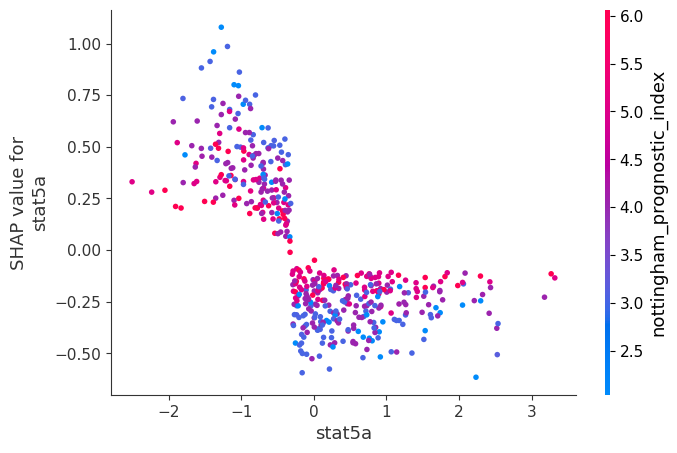

In [106]:
# inspecting the stat5a gene SHAP value
shap.dependence_plot('stat5a', shap_values, X_test)

STAT5A gene: negative z scores are associated with higher SHAP values. Interestingly, the high and low extremes for SHAP values correspond to lower Nottingham Prognostic Index values. 

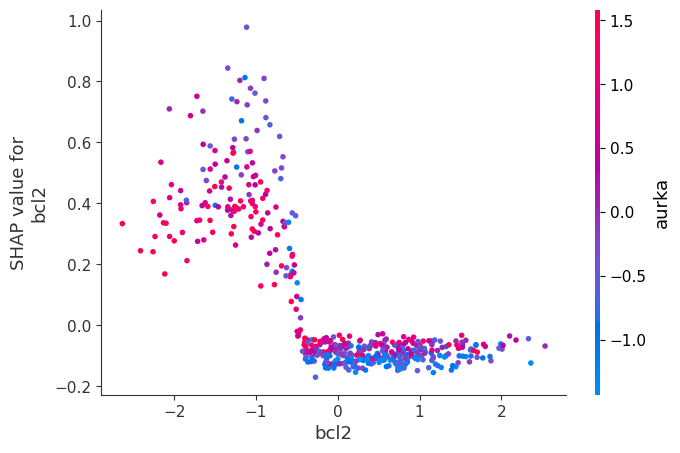

In [107]:
# inspecting the bcl2 gene SHAP value
shap.dependence_plot('bcl2', shap_values, X_test)

BCL2 gene: Z scores under -0.6 correspond to positive SHAP values, ranging from 0 to 1, and they are not tightly clustered. Z scores over this value all have SHAP values of approximately -0.1.  So, higher Z scores don’t have a large contribution towards survival, but negative z scores can for some patients. 



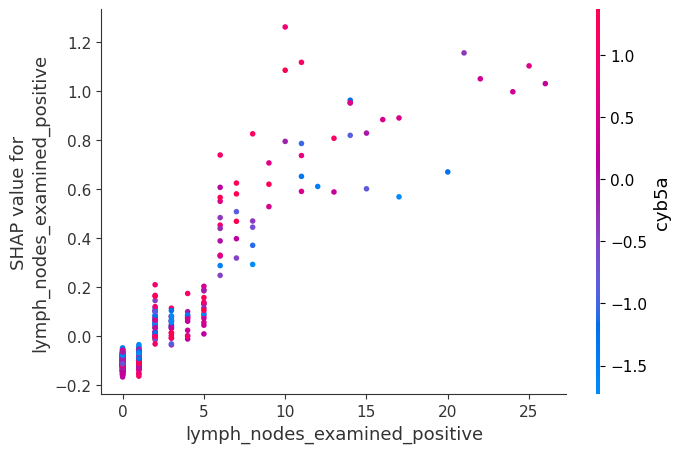

In [108]:
# inspecting the lymph nodes examined positvive SHAP value
shap.dependence_plot('lymph_nodes_examined_positive', shap_values, X_test)

Lymph Nodes Examined Positive are integers, and as the number increased, the SHAP value increased in a roughly linear manner, and the spread got wider as the number of nodes increased. Most patients had fewer positive nodes, and after 2 positive nodes the SHAP value was positive, ranging from 0 to 1.2. According to this metric, the higher the positive node count, the more contribution there is towards cancer death. 

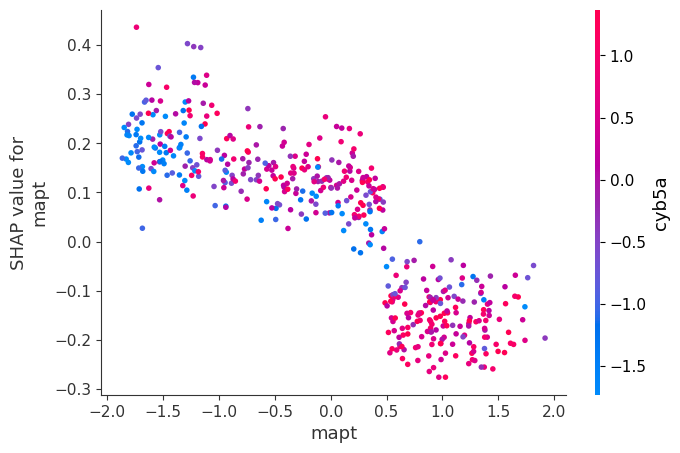

In [109]:
# inspecting the mapt gene SHAP value
shap.dependence_plot('mapt', shap_values, X_test)

MAPT gene: These clusters were less tight than the others, and ranged from -0.3 to 0.4. The positive SHAP values were for z scores under 0.5. 

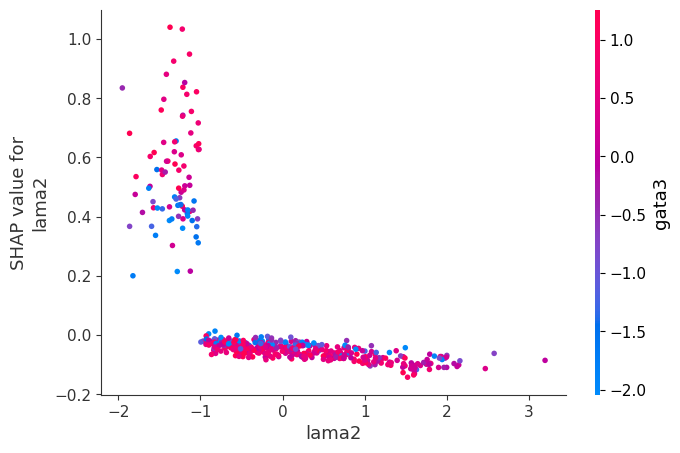

In [110]:
# inspecting the lama2 gene SHAP value
shap.dependence_plot('lama2', shap_values, X_test)

LAMA2 gene: This one is interesting, the z scores under -2 and -1 were tightly clustered along the x axis, but widely spread on the y axis, ranging from 0.2 to 1, and those with SHAP scores over 0.6 also had primarily positive Z scores for the GATA3 gene. The SHAP value for z scores over -1 were tightly clustered around 0, indicating that there was almost no contribution towards survival with scores over -1, but a significant impact under -1. 

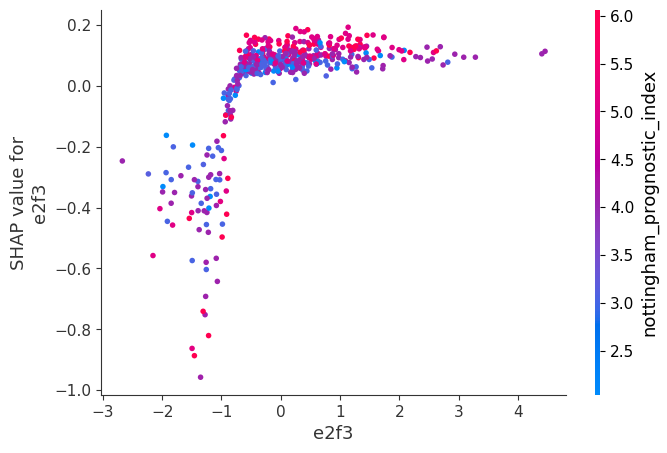

In [111]:
# inspecting the e2f3 gene SHAP value
shap.dependence_plot('e2f3', shap_values, X_test)

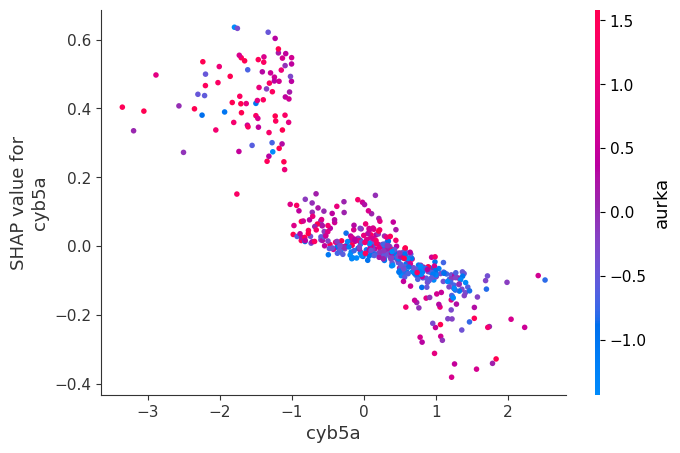

In [112]:
# inspecting the cyb5a gene SHAP value
shap.dependence_plot('cyb5a', shap_values, X_test)

E2F3 gene: Under a z score of -1, the SHAP values ranged from 0 to -1, not tightly clustered. Over a z score of 1, the SHAP VALUES were tightly clustered between 0 and 0.2, with most of the higher SHAP values having a Nottingham Prognostic Index over 5. This gene has more contributions towards positive outcomes than towards death.

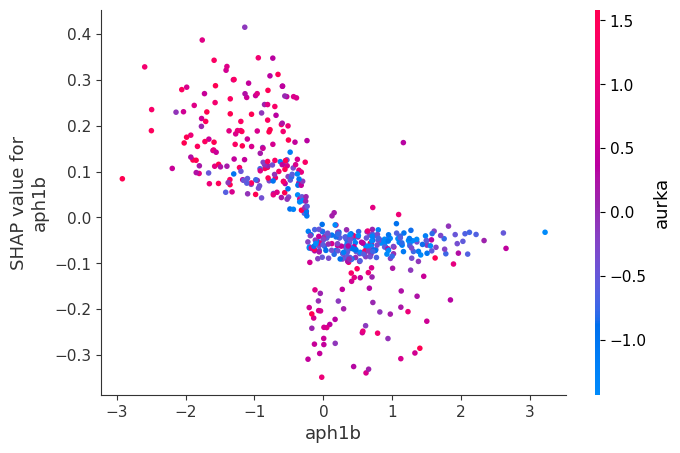

In [113]:
# inspecting the aph1b gene SHAP value
shap.dependence_plot('aph1b', shap_values, X_test)


APH1B gene: Z scores under -0.2 corresponded with contributions towards cancer death, with SHAP values ranging from 0 to 0.4. Z scores over -0.2 corresponded with contributing towards better outcomes; for patients who also had a positive AURKA z score, the outcomes were best, with z scores ranging from -0.1 to -0.35. Note that most of the postive SHAP values for APH1B also had a positive AURKA score. 


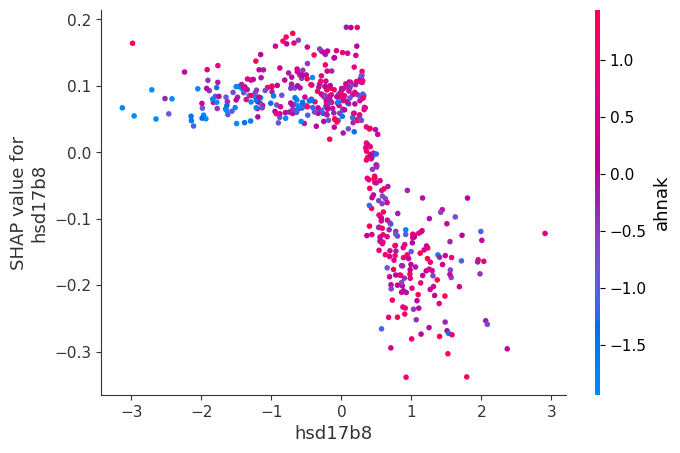

In [114]:
# inspecting the hsd17b8 gene SHAP value
shap.dependence_plot('hsd17b8', shap_values, X_test)

HSD17B8 gene: Z scores under 0 were associated with SHAP values between 0 and 0.2, and z scores over 0 were associated with SHAP values between 0 and -0.3.

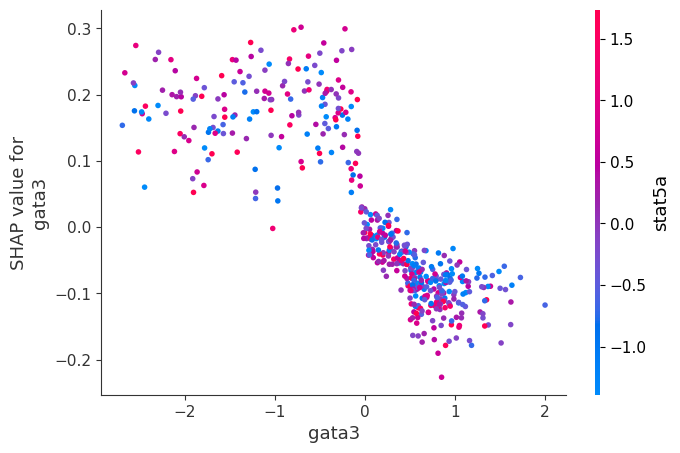

In [115]:
# inspecting the gat3 gene SHAP value
shap.dependence_plot('gata3', shap_values, X_test)


GATA3 gene: a scores under 0 were not tightly clustered, and associated with SHAP values between 0 and 0.3.  Z scores over 0 were associated with tightly clustered SHAP values between 0 and -0.2. 


# 4.8 Conclusions <a id='4.8_conclusions'></a>

In this notebook I decided to drop the PCA models, as they didn't show much improvement in the F1 score, and we were sacrificing  interpretability. As there was significant overfitting happening due to imbalanced classes, I implemented two resampling techniques, SMOTE for oversampling and NearMiss for undersampling. I chose these as they are more advanced resampling techniques that should minimize overfitting.  

The models I ran were Logistic Regression, Random Forest, XG Boost Classifier and LGBM Classifier. For each model, I ran it with oversampling and undersampling, and then performed hyperparamter tuning and ran the oversampled and undersampled sets again with the new parameters. For each iteration of a model, I performed 5 fold cross validation and found the mean total F1 score for each fold, I printed the classification report, and printed a confusion matrix. Because the goal of this project is to identify true cancer deaths, I used the class 1 F1 score as the primary metric I was looking at, and also checked the confusion matrix to make sure that the true positives were maximized and the false negatives were minimized. I am not as concerned with false positives, as living longer than expected is a much better situation for patients than having a more aggressive cancer/dying sooner from cancer than expected. 

The best model was the undersampled & tuned XG Boost model. However, the class 1 F1 score was only 0.57, which is only slightly better than flipping a coin. Upon inspecting the precision and recall scores, the recall is actually quite good at 0.81, but with precision scores of 0.44; this model does correctly identify most true positives, but there is a high false positive rate. This could be counteracted by further testing in the clinic, and closely monitoring disease progress. 

After picking the best model, I performed SHAP (Shapley Additive Explanations), which in our case is able to quantify how much each features contributes towards our target variable, which is a binary value of 1 (death from cancer) or 0 (survival or death from other causes). We started off with 693 features in the original dataset, and by looking at the summary plot it is easy to see that there are a relatively small number of features that potentially have a large contribution towards patient outcome. Interestingly, none of the genetic mutation data appears here, indicating that the number of mutations on a gene may not impact the outcome very much, but most of the features were genes for which we have the z scores. There were also a few clinical attributes that look to be important, and they are what I would expect, as these are part of how doctors already anticipate patient outcomes: tumor size, Nottingham Prognostic Index, and the  number of positive lymph nodes. 

The z scores of certain genes measurably contribute towards patient outcome, which can be seen on the plots of the z scores vs SHAP values of individual genes. For most of the genes inspected, the data falls into 2 distinct clusters: those with SHAP values over 0 (contributing towards cancer death), and those with SHAP values under 0 (contributing towards NO cancer death). In these cases, we can clearly see that that the range of the z score is very important. It should also be noted that some genes need to be looked at together, as the presence of a certain range of z scores for one gene can correlate with higher or lower SHAP values for another gene. For example, for both the aph1b and cyb5a genes, most of the data points with lower SHAP values also had aurka gene z scores under 0. 

<b>According to SHAP on the tuned and oversampled XG BOOST model, the following genes contribute towards cancer death, with SHAP values over 0.1:</b>

<i>High z scores associated with high SHAP values</i>:

* aurka (NOTE: this gene had the highest SHAP value and also appears to interact with other genes)
* e2f3

<i>Low z scores associated with high SHAP values:</i>

* stata5a
* bcl2
* mapt
* lama2
* cyb5a
* aph1b
* hsd17b8
* gata3

Further studies should be done on how the z scores of these genes correlate with patient outcomes. Understanding this relationship would not only improve anticipating patient outcomes, but could also lead to improved treatments. 

# 4.9 Next Steps <a id='4.9_next'></a>

In the process of building a model to predict cancer death and find out what factors contribute to this, questions have come to mind that could potentially improve the model. While this project is wrapped up, it would be interesting to investigate the following questions in future work:

1. What does the chosen model look like when we remove the genetic mutation section of the data? Does this change the output of the model at all? Simplifying the data needed for the model would make it easier and less expensive to implement for future patients. 

2. Modeling based on the survival time could give different results than on binary outcome, and would be interesting to look into. How would the results change if we build a model based on the suvival time metric rather than binary outcome?

3. In the prior notebook I made the decision to simplify the data from the genetic mutation section; it was originally a string containing between 0 and 10 genetic mutations, and I changed it to be a binary 1 or 0 indicating if mutations were present or not. I would be curious to see what mutations were present for the genes I noted above, as that could be an important factor. Looking back at the EDA notebook, I see that some of the genes with high SHAP values are also among the most commonly occuring genes with mutations. Would expanding the original genetic mutation data with the 'get dummies' method make our model better or worse? Would we be able to pull more insights from SHAP with this information included?